## Project 2

Some Project Description

### Part 1: Object Detection

#### Select a 3D object detection model suitable for your needs.

Here some explanation which model is selected

#### Configure the selected model to function within your local setup (this may vary depending on the model chosen).

Explain some configs

In [39]:
from sfa.models import fpn_resnet
import torch
from tools.model_config import create_model_config
from tools.bev_tools import create_bev_config

bev_configs = create_bev_config()
models_config = create_model_config(model_name='fpn_resnet', configs=bev_configs)
# create model

num_layers = 18
model = fpn_resnet.get_pose_net(num_layers=num_layers,
                                heads=models_config.heads,
                                head_conv=models_config.head_conv,
                                imagenet_pretrained=False)

# load pre-trained weights
pretrained_path = './checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth'
model.load_state_dict(torch.load(pretrained_path, map_location='cpu'))

model = model.to(device='cpu')
model.eval()

student task ID_S3_EX1-3


PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

#### Extract point cloud information from the dataset provided.

In [40]:
import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools
import os

DATASET_PATH = './dataset'

# Read frame from file
frame = dataset_tools.read_frame(os.path.join(DATASET_PATH, "frame_194.pb"))
# Extract point cloud from frame
pcl = dataset_tools.decode_lidar(frame.lidars[0])

#### Calculate a Bird's Eye View perspective of the point cloud.

In [41]:
from tools import bev_tools
import numpy as np

lidar_bev = bev_tools.pcl_to_bev(pcl, bev_configs)
lidar_bev_input = torch.Tensor(lidar_bev[np.newaxis, ...].copy())

#### Forward the Bird's Eye View perspective to the selected detection model.

In [42]:
from sfa.utils.torch_utils import _sigmoid
from sfa.utils.evaluation_utils import decode, post_processing, draw_predictions, get_labels

# feed LIDAR data to model
with torch.no_grad():
    outputs = model(lidar_bev_input)

#### Extract vehicle data from the perspective obtained.

In [43]:
import cv2

#post-processing model output
outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])

# detections
detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'], outputs['dim'], K = models_config.K)
detections = detections.cpu().numpy().astype(np.float32)
detections = post_processing(detections, models_config.num_classes, models_config.down_ratio, models_config.peak_thresh)

image_bev_map = (np.transpose(lidar_bev, (1, 2, 0)) * 255).astype(np.uint8)
image_bev_map = cv2.resize(image_bev_map, (bev_configs.bev_width, bev_configs.bev_height))   ### use same width, height as in BEV calculation
image_bev_map = draw_predictions(image_bev_map, detections[0].copy(), models_config.num_classes)

# label detctions
pred_labels = get_labels(detections)


#### Lidar detections

In [44]:
from PIL import Image, ImageDraw
from sfa.data_process.kitti_bev_utils import get_corners

img = Image.fromarray(image_bev_map)
draw = ImageDraw.Draw(img)

labels_detections = []

for i in range(len(frame.lidars[0].detections)):
    detection = frame.lidars[0].detections[i]
    y, x, z = detection.pos
    l, w, h = detection.scale
    _, _, yaw = detection.rot

    x = (x - bev_configs.lim_x[0]) / (bev_configs.lim_y[1] - bev_configs.lim_y[0]) * bev_configs.bev_width
    y = (y - bev_configs.lim_x[0]) / (bev_configs.lim_x[1] - bev_configs.lim_x[0]) * bev_configs.bev_height
    
    x += bev_configs.bev_width / 2

    z = z - bev_configs.lim_z[0]
    w = w / (bev_configs.lim_y[1] - bev_configs.lim_y[0]) * bev_configs.bev_width
    l = l / (bev_configs.lim_x[1] - bev_configs.lim_x[0]) * bev_configs.bev_height
    yaw = -yaw
    
    label_box = get_corners(x, y, w , l, yaw)
    if np.all((label_box>= 0) & (label_box <= bev_configs.output_width)):
        labels_detections.append(label_box)
    
    draw.polygon(label_box, outline='red', width=3)

img.show()

#### Use performance measures to evaluate the model's effectiveness.

In [45]:
from sfa.utils.evaluation_utils import measure_detection_performance

ious, metrics = measure_detection_performance(pred_labels,labels_detections,0.5)
_, tp, fn, fp = metrics

print('ious:', ious)
print('True positives',tp)
print('False negatives',fn)
print('False positives',fp)

ious: [0.7021229425189699, 0.6351532226012253, 0.6431016676952667, 0.6253080547365353]
True positives 4
False negatives 8
False positives 0


#### Putting all together

In [49]:
from tools.lidar_tools import label_extraction

# get all frames
files = os.listdir(DATASET_PATH)

# get bev for every frame
stacked_tensors_bev = []
labels = []
for file in files:
    labels_detections = []
    # get a frame 
    frame = dataset_tools.read_frame(os.path.join(DATASET_PATH, file))

    # convert a rame to pcl
    pcl = dataset_tools.decode_lidar(frame.lidars[0])

    # get a bev from pcl
    lidar_bev = bev_tools.pcl_to_bev(pcl, bev_configs)
    lidar_bev_input = torch.Tensor(lidar_bev[np.newaxis, ...].copy())

    # add to the all bevs
    stacked_tensors_bev.append(lidar_bev_input)

    # label extraciton from frame
    label = label_extraction(frame,bev_configs)
    labels.append(label)


#convert to tensor torch
stacked_tensors_bev = torch.cat(stacked_tensors_bev,0)

# model prediction
with torch.no_grad():
    outputs = model(stacked_tensors_bev)

#post-processing model output
outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])

# detections
detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'], outputs['dim'], K = models_config.K)
detections = detections.cpu().numpy().astype(np.float32)
detections = post_processing(detections, models_config.num_classes, models_config.down_ratio, models_config.peak_thresh)

# Convert labels into correct format:
pred_labels = []
for detect in detections:
    preds = get_labels([detect])
    pred_labels.append(preds)
    


# measure individual perfrmance: 
measurments_all = []
for pred, label in zip(pred_labels,labels):
    measurments = measure_detection_performance(pred,label)
    measurments_all.append(measurments)


# Calculate Performance overall:
ious = []
pos_neg = []

for item in measurments_all:
    ious.append(item[0])
    pos_neg.append(item[1])


pos_neg = np.array(pos_neg)
_ , tp, fn, fp = pos_neg.sum(axis=0)


precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Ious stats
ious_all = [iou for tupl in ious for iou in tupl]
std_iou = np.std(ious_all)
mean_iou = np.mean(ious_all)

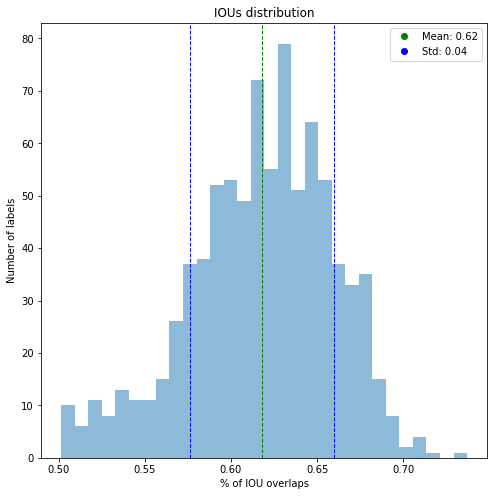

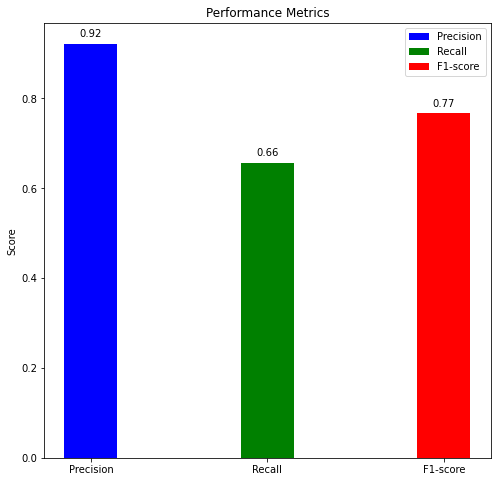

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Sample list of values

# Plot histogram

plt.figure(figsize=(8, 8))
plt.hist(ious_all, bins=30, alpha=0.5, label='Histogram')


# Mark mean and std on the plot
plt.axvline(mean_iou, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean_iou:.2f}')
plt.axvline(mean_iou + std_iou, color='blue', linestyle='dashed', linewidth=1, label=f'Std: {std_iou:.2f}')
plt.axvline(mean_iou - std_iou, color='blue', linestyle='dashed', linewidth=1)

# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='green', label=f'Mean: {mean_iou:.2f}', linestyle='None'),
                  plt.Line2D([0], [0], marker='o', color='blue', label=f'Std: {std_iou:.2f}', linestyle='None')]

# Add legend with custom handles and labels
plt.legend(handles=legend_handles)

plt.title("IOUs distribution")
plt.xlabel("% of IOU overlaps")
plt.ylabel("Number of labels")

# Show plot
plt.show()


import matplotlib.pyplot as plt

# Example data
import matplotlib.pyplot as plt

# Example data
bar_width = 0.3
categories = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 8))  # Adjust size of the plot

plt.bar(categories[0], precision, color='blue', label='Precision', width=bar_width)
plt.bar(categories[1], recall, color='green', label='Recall', width=bar_width)
plt.bar(categories[2], f1_score, color='red', label='F1-score', width=bar_width)

# Annotate values on top of bars
plt.text(categories[0], precision + 0.01, f'{precision:.2f}', ha='center', va='bottom', color='black')
plt.text(categories[1], recall + 0.01, f'{recall:.2f}', ha='center', va='bottom', color='black')
plt.text(categories[2], f1_score + 0.01, f'{f1_score:.2f}', ha='center', va='bottom', color='black')

# Adding legend in the right corner
plt.legend(loc='upper right')

# Adding labels and title
plt.ylabel('Score')
plt.title('Performance Metrics')

# Show plot
plt.show()




### Part 2: Multi-Object Tracking

In [ ]:


"""
  values=[
    _descriptor.EnumValueDescriptor(
      name='CAR', index=0, number=0,
      serialized_options=None,
      type=None),
    _descriptor.EnumValueDescriptor(
      name='TRUCK', index=1, number=1,
      serialized_options=None,
      type=None),
    _descriptor.EnumValueDescriptor(
      name='PEDESTRIAN', index=2, number=2,
      serialized_options=None,
      type=None),
    _descriptor.EnumValueDescriptor(
      name='CYCLIST', index=3, number=3,
      serialized_options=None,
      type=None),

"""


"""
'Pedestrian': 0,
    'Car': 1,
    'Cyclist': 2,
    'Van': 1,

"""